In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
exp_model = DoubleNet.load('exponential_1x2_0_inf_experiment_data/').to('cpu')

In [2]:
unit_model = DoubleNet.load('unit_1x2_0_1_experiment_data/').to('cpu')

In [42]:
bid = torch.tensor([[[1., 0.]]])

In [16]:
exp_model.neural_network_forward(bid)

tensor([[[0.1785, 0.1053]]], grad_fn=<AddBackward0>)

In [4]:
unit_model.neural_network_forward(bid)

tensor([[[ 0.4777, -0.0319]]], grad_fn=<AddBackward0>)

In [23]:
exp_model.sinkhorn_rounds = 20
exp_model(bid)

(tensor([[[0.9028, 0.6824]]], grad_fn=<ViewBackward>),
 tensor([[0.9537]], grad_fn=<MulBackward0>))

In [43]:
output1 = []
output2 = []
unit_model.sinkhorn_epsilon = 1e-2
for i in range(1, 300, 5):
    unit_model.sinkhorn_rounds = i
    alloc, pay = unit_model(bid)
    output1.append(alloc[:, :, 0].item())

unit_model.sinkhorn_epsilon = 5e-2
for i in range(1, 300, 5):
    unit_model.sinkhorn_rounds = i
    alloc, pay = unit_model(bid)
    output2.append(alloc[:, :, 0].item())


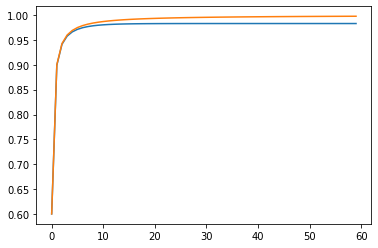

In [44]:
plt.plot(output2)
plt.plot(output1)

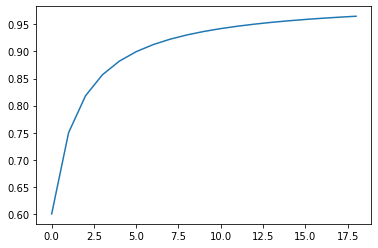

In [24]:
plt.plot(output1)

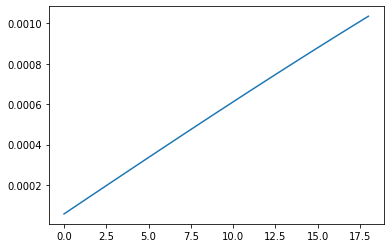

In [25]:
plt.plot(output2)

In [58]:
padded = -torch.nn.functional.pad(
            exp_model.neural_network_forward(bid),
            [0, 1, 0, 1],
            mode='constant',
            value=0
        )
agent_tiled_marginals = exp_model.agents_marginal.repeat(1, 1)
item_tiled_marginals = exp_model.items_marginal.repeat(1, 1)

In [45]:
padded = -torch.nn.functional.pad(
            unit_model.neural_network_forward(bid),
            [0, 1, 0, 1],
            mode='constant',
            value=0
        )
agent_tiled_marginals = unit_model.agents_marginal.repeat(1, 1)
item_tiled_marginals = unit_model.items_marginal.repeat(1, 1)

In [7]:
agent_tiled_marginals

tensor([[1., 2.]])

In [8]:
item_tiled_marginals

tensor([[1., 1., 1.]])

In [9]:
import double_net.sinkhorn as sh

In [13]:
padded

tensor([[[-0.4777,  0.0319, -0.0000],
         [-0.0000, -0.0000, -0.0000]]], grad_fn=<NegBackward>)

In [56]:
x = sh.log_sinkhorn_plan(padded, agent_tiled_marginals, item_tiled_marginals, 5e-2, 1000)
x

tensor([[[0.9831, 0.0017, 0.0153],
         [0.0169, 0.9983, 0.9847]]], grad_fn=<ExpBackward>)

In [11]:
padded.shape

torch.Size([1, 2, 3])

In [ ]:
def new_log_sinkhorn(dist, a, b, ep, rounds):
    

In [71]:
x.sum(dim=1)

tensor([[1.0000, 1.0000, 2.0000]], grad_fn=<SumBackward1>)

In [73]:
x.sum(dim=2)

tensor([[1.9999, 2.0001]], grad_fn=<SumBackward1>)

In [63]:
sh.sinkhorn_plan(padded, agent_tiled_marginals, item_tiled_marginals, 5e-2, 20, debug=True)

mean norm of differences in u at each iteration [0.19537919759750366, 0.0647846907377243, 0.023228568956255913, 0.008469514548778534, 0.003100569359958172, 0.0011363666271790862, 0.0004166474100202322, 0.0001527628191979602, 5.6032022257568315e-05, 2.0577885152306408e-05, 7.546581400674768e-06, 2.770263790807803e-06, 1.044464056576544e-06, 3.686343745812337e-07, 1.2489448408814496e-07, 6.006850128414953e-08, 5.960464477539063e-08, 7.450580596923828e-09, 2.9802322387695312e-08, 0.0]
mean norm of differences in v at each iteration [0.8414322733879089, 0.3651326596736908, 0.1430041640996933, 0.05375625193119049, 0.01989533193409443, 0.007320683915168047, 0.0026874630711972713, 0.0009861523285508156, 0.00036213002749718726, 0.00013261981075629592, 4.869944677921012e-05, 1.8319122318644077e-05, 6.735324859619141e-06, 2.41177963289374e-06, 9.573923307470977e-07, 4.777675712830387e-07, 4.76837158203125e-07, 6.664001972467304e-08, 0.0, 0.0]


tensor([[[0.9028, 0.6824, 0.4148],
         [0.0972, 0.3176, 1.5852]]], grad_fn=<ViewBackward>)